In [29]:
!pip install arviz
#!pip install pymc3==3.9

     |████████████████████████████████| 1.5MB 5.0MB/s 
     |████████████████████████████████| 727kB 37.0MB/s 
     |████████████████████████████████| 4.3MB 46.1MB/s 
     |████████████████████████████████| 296kB 45.8MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1


In [33]:
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import seaborn
warnings.simplefilter(action="ignore", category=FutureWarning)

import arviz as az

# Exercise 1

In [3]:
df = pd.read_csv("exam_question1.csv")
x01 = df['x1']
x02 = df['x2']

# target
y0 = df['y']
df.sample(5)

,x1,x2,y
48,-0.14,0.66,0.0
35,-0.94,1.38,0.0
2,0.74,-0.29,0.0
3,0.56,-0.34,1.0
21,0.34,0.61,0.0


<Figure size 432x288 with 0 Axes>

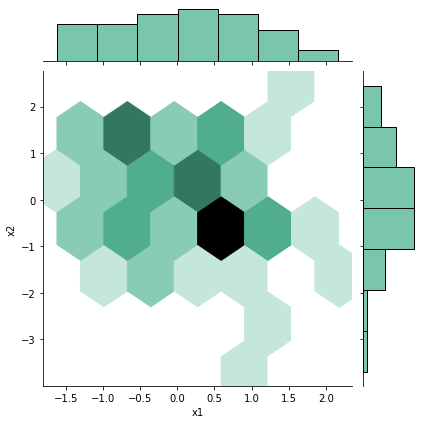

In [6]:
plt.figure()
seaborn.jointplot(df['x1'],df['x2'], df['y'], kind="hex", color="#4CB391")
plt.xlabel("temperature")
plt.ylabel("pressure");

In [18]:
# 1 = C
# 
with pm.Model() as logistic_model:
  alpha = pm.Normal('alpha', 0.0, sd=30)
  beta1  = pm.Normal('beta1',  0.0, sd=30)
  beta2  = pm.Normal('beta2',  0.0, sd=30)

  # complete the model
  #sig = pm.Uniform('sig',.0001,30)                   #ADDED
  #mu = pm.Deterministic('mu', pm.math.invlogit(alpha + (pm.math.dot(X, beta1)+beta2)) #ADDED
  mu = pm.math.invlogit(alpha + beta1 * x01 + beta2 * x02)
  #like = pm.Normal('like', mu, #sig, observed = y0)  #ADDED
  like = pm.Bernoulli("like", mu, observed=y0)        #ADDED

with logistic_model:
    approx = pm.fit(80000)#ADVI method

posterior = approx.sample(10000)

Average Loss = 17.92: 100%|██████████| 80000/80000 [00:46<00:00, 1721.97it/s]
Finished [100%]: Average Loss = 17.922


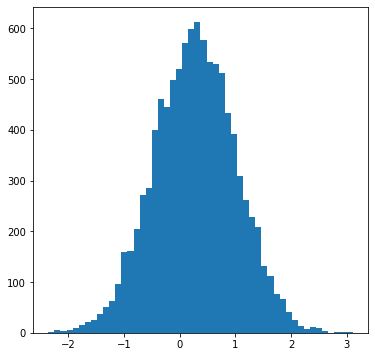

In [19]:
plt.figure(figsize=(6,6))
plt.hist(0.01 * posterior['beta1'] + posterior['alpha'], bins=50)
plt.show()

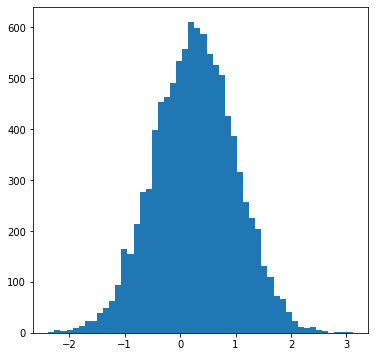

In [20]:
plt.figure(figsize=(6,6))
plt.hist(0.008 * posterior['beta2'] + posterior['alpha'], bins=50)
plt.show()

# Exercise 2

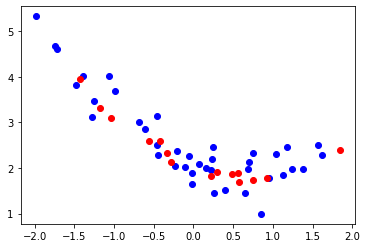

In [24]:
df2 =pd.read_csv("exercise2_data_sensor1.csv")
x1 =df2['temperature']
y1 =df2['pressure']

df3=pd.read_csv("exercise2_data_sensor2.csv")
x2=df3['temperature']
y2=df3['pressure']

plt.scatter(x1, y1, color='b',label="sensor 1")
plt.scatter(x2, y2, color='r',label="sensor 2")

<Figure size 432x288 with 0 Axes>

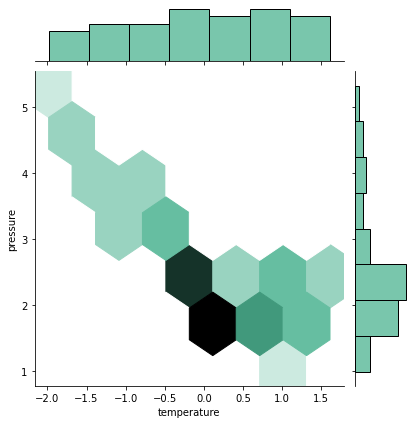

In [ ]:
plt.figure()
seaborn.jointplot(df2['temperature'], df2['pressure'], kind="hex", color="#4CB391")
plt.xlabel("temperature")
plt.ylabel("pressure");

<Figure size 432x288 with 0 Axes>

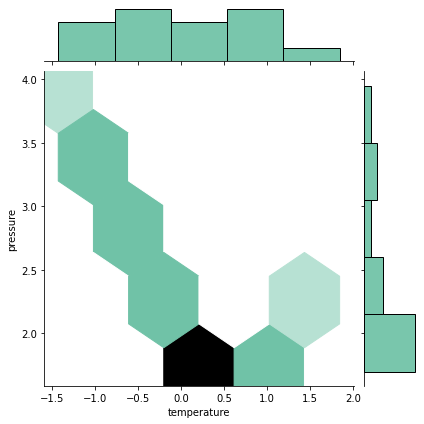

In [ ]:
plt.figure()
seaborn.jointplot(df3['temperature'], df3['pressure'], kind="hex", color="#4CB391")
plt.xlabel("temperature")
plt.ylabel("pressure");

In [25]:
deg = 4
Xscalar0 = x1#.reshape(-1,1)
for i in range(1, deg+1):
    Xscalar0 = np.hstack([Xscalar0, x1#.reshape(-1,1)
    **i]) #polynomial features

Xscalar1 = x2#.reshape(-1,1)
for i in range(1, deg+1):
    Xscalar1 = np.hstack([Xscalar1, x2#.reshape(-1,1)
    **i]) #polynomial features

Average Loss = 33.982: 100%|██████████| 80000/80000 [00:51<00:00, 1548.30it/s]
Finished [100%]: Average Loss = 33.98


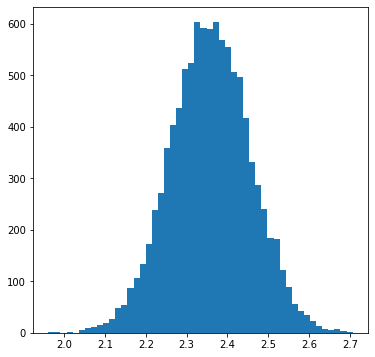

In [42]:
# 2 = B
# x = 1.8

with pm.Model() as poly_reg:        
    alpha  = pm.Normal('alpha', 0.0, sd=30)
    beta1   = pm.Normal('beta1', 0.0, sd=30)
    beta2   = pm.Normal('beta2', 0.0, sd=30)
    sigma1 = pm.Uniform('sigma1', 0.0001, 30)
    sigma2 = pm.Uniform('sigma2', 0.0001, 30)
    #complete the model

    #Scalar data x1 temperature
    #mu0 = alpha + pm.math.dot(Xscalar0, beta1)           #ADDED
    mu0 = alpha + beta1*x1 + beta2*pow(x1, 2)             #ADDED
    like0 = pm.Normal('Like0', mu0, sigma1, observed=y1)  #ADDED

    #Scalar data x2 temperature
    #mu1 = alpha + pm.math.dot(Xscalar1, beta2)           #ADDED
    mu1 = alpha + beta1*x2 + beta2*pow(x2, 2)             #ADDED
    like1 = pm.Normal('Like1', mu1, sigma2, observed=y2)  #ADDED

with poly_reg:
    approx = pm.fit(80000)#ADVI
    
posterior = approx.sample(10000)

#pm.plot_posterior(posterior, color='LightSeaGreen', kind='hist', bins=50)

plt.figure(figsize=(6,6))
plt.hist(posterior['alpha'] + (posterior['beta1'] * 1.8) + posterior['beta2'] * 1.8**2, bins=50)
plt.show()

In [ ]:
pm.plot_posterior(posterior, color='LightSeaGreen', kind='hist', bins=50)

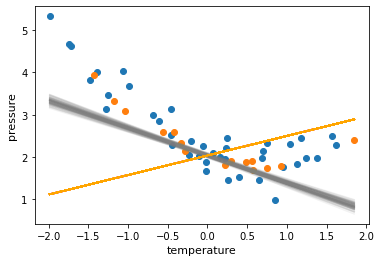

In [44]:
#ADDED
xx = np.linspace(np.min(np.hstack([x1,x2])),np.max(np.hstack([x1,x2])))
for i in range(100):
  plt.plot(xx, xx * posterior['beta1'][i]+posterior['alpha'][i], c='gray', alpha=.1)
  plt.plot(xx, xx * posterior['beta2'].mean()+posterior['alpha'].mean(), c='orange')

plt.scatter(x1, y1)
plt.scatter(x2, y2)
plt.xlabel("temperature", fontsize=11)
plt.ylabel("pressure", fontsize=11)
plt.show()

# Exercise 3

In [45]:
with pm.Model() as my_model:        
    alpha  = pm.Normal('alpha', 0, 30)
    beta  = pm.Normal('beta', 0, 30)
    sigma  = pm.Uniform('sigma1', 0.001, 15)
    mu=alpha + beta*x1
    like = pm.Normal('likelihood', pm.math.invlogit(mu), sigma, observed=y1)

In [46]:
with pm.Model() as my_model:        
    alpha  = pm.Normal('alpha', 0, 30)
    beta  = pm.Normal('beta', 0, 30)
    sigma  = pm.Uniform('sigma', 0.001, 15)
    mu=alpha + beta*x1
    like = pm.Normal('likelihood', mu, sigma, observed=y1)

In [50]:
#D due to ^3 mu but pm.Unif() doesn't work...
with pm.Model() as my_model:        
    alpha  = pm.Unif('alpha', 2,5)
    gamma  = pm.Normal('gamma', -3.0, sd=3)
    sigma  = pm.Uniform('sigma1', 0.001, 15)
    mu=gamma*x**3/(alpha+x)
    like = pm.Normal('likelihood', mu, sigma, observed=y)

AttributeError: ignored

In [49]:
with pm.Model() as my_model:        
    alpha  = pm.Unif('alpha', 2,5)
    gamma  = pm.Normal('gamma', -3.0, sd=3)
    sigma  = pm.Uniform('sigma1', 0.001, 15)
    mu=alpha+gamma*x
    like = pm.Normal('likelihood', mu, sigma, observed=y)

AttributeError: ignored

# Exercise 4

In [ ]:
# 𝑛=640 tosses,  340 Heads and 300 Tails

h = 340/640
t = 300/640
y = h+t

with pm.Model() as coin_model:
    # prior
    theta = pm.Uniform("theta", 0,1)
    
    #like
    like = pm.Bernoulli("like", theta, observed = h)
    
with coin_model:    
    posterior = pm.sample(15000, tune=3000, chains=1)

len(np.where(posterior['theta']>=0.5)[0])/len(posterior['theta'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 18000/18000 [00:08<00:00, 2209.13it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


0.2472

In [53]:
with pm.Model() as coin_model:
    # prior
    theta = pm.Uniform("theta", 0,1)
    
    #like
    like = pm.Bernoulli("like", theta, observed = t)
    
with coin_model:    
    posterior = pm.sample(15000, tune=3000, chains=1)

len(np.where(posterior['theta']>=0.5)[0])/len(posterior['theta'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 18000/18000 [00:10<00:00, 1780.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


0.2472

In [54]:
with pm.Model() as coin_model:
    # prior
    theta = pm.Uniform("theta", 0,1)
    
    #like
    like = pm.Bernoulli("like", theta, observed = y)
    
with coin_model:    
    posterior = pm.sample(15000, tune=3000, chains=1)

len(np.where(posterior['theta']>=0.5)[0])/len(posterior['theta'])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [theta]
100%|██████████| 18000/18000 [00:08<00:00, 2219.88it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


0.7536

# Exercise 5

In [ ]:
for i in range(1,8):
  

In [ ]:
# 5 = D
np.mean(posterior["theta"][:,1]+posterior["theta"][:,3]+posterior["theta"][:,5])

# Exercise 6

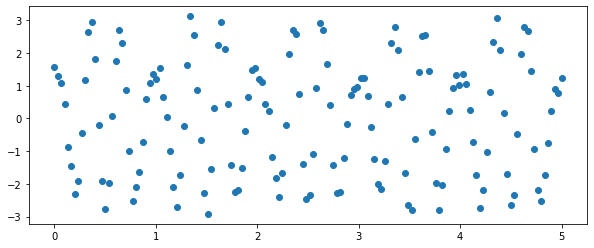

In [65]:
df6 = pd.read_csv("exam_question6.csv")
x6 = df6['x'].to_numpy()
y6 = df6['y'].to_numpy()
plt.figure(figsize=(10,4))
plt.scatter(x6, y6)
plt.show()

In [88]:
# 6 = B
# x = 6
with pm.Model() as function_model:
    alpha = pm.Normal('alpha',.0,30)
    #beta = pm.Normal('beta',.0,30)
    sigma = pm.Uniform('sigma',0.0001,30)

    #mu = pm.Deterministic('mu', alpha + np.dot(df6, beta))
    mu = pm.math.dot(x6, alpha)
    like = pm.Normal('Like', mu, sigma, observed=y6)

In [89]:
with function_model:
  trace = pm.sample(5000, tune=1000, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, alpha]
100%|██████████| 6000/6000 [00:06<00:00, 893.05it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


(array([  1.,   1.,   0.,   2.,   1.,   1.,   4.,   5.,  19.,  16.,  28.,
         43.,  54.,  64.,  71.,  99., 141., 149., 185., 200., 227., 267.,
        272., 321., 279., 287., 294., 282., 248., 249., 225., 192., 156.,
        150., 122.,  81.,  62.,  64.,  39.,  30.,  18.,  18.,  13.,   4.,
          7.,   3.,   3.,   1.,   1.,   1.]),
 array([-1.13457678, -1.08970164, -1.04482651, -0.99995137, -0.95507624,
        -0.91020111, -0.86532597, -0.82045084, -0.7755757 , -0.73070057,
        -0.68582543, -0.6409503 , -0.59607516, -0.55120003, -0.5063249 ,
        -0.46144976, -0.41657463, -0.37169949, -0.32682436, -0.28194922,
        -0.23707409, -0.19219895, -0.14732382, -0.10244869, -0.05757355,
        -0.01269842,  0.03217672,  0.07705185,  0.12192699,  0.16680212,
         0.21167726,  0.25655239,  0.30142752,  0.34630266,  0.39117779,
         0.43605293,  0.48092806,  0.5258032 ,  0.57067833,  0.61555347,
         0.6604286 ,  0.70530373,  0.75017887,  0.795054  ,  0.83992914,
 

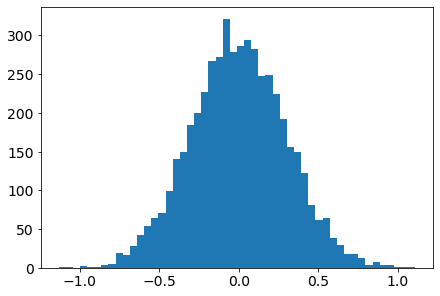

In [98]:
az.plot_dist(trace['alpha'])
plt.hist(trace['alpha']*6,bins=50)

<Figure size 432x288 with 0 Axes>

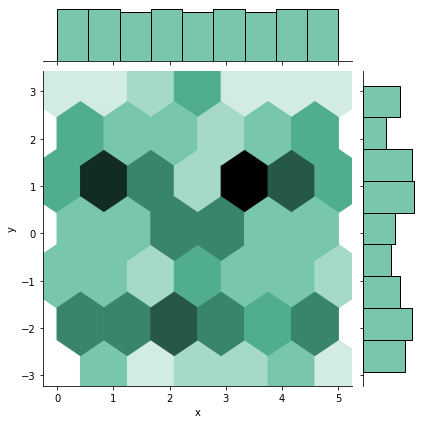

In [92]:
plt.figure()
seaborn.jointplot(df6['x'], df6['y'], kind="hex", color="#4CB391")
plt.xlabel("x")
plt.ylabel("y");

---

In [91]:
plt.hist(np.dot(x6, trace['alpha'].T),bins='auto')

ValueError: ignored